# Twitter Analytics

Streaming is something that is rapidly advancing and changing fast, there are multiple new libraries every year, new and different services always popping up, and what is in this notebook may or may not apply to you. Maybe your looking for something specific on Kafka, or maybe you are looking for streaming about twitter, in which case Spark might be overkill for what you really want. Realistically speaking each situation is going to require a customized solution. Some great resources for Python and Spark Streaming:
- http://spark.apache.org/docs/latest/streaming-programming-guide.html#spark-streaming-programming-guide
- https://www.rittmanmead.com/blog/2017/01/getting-started-with-spark-streaming-with-python-and-kafka/
- http://nbviewer.jupyter.org/github/ibm-cds-labs/spark.samples/blob/master/notebook/DashDB%20Twitter%20Car%202015%20Python%20Notebook.ipynb

Spark has pretty well known Streaming Capabilities, if streaming is something you've found yourself needing at work then you are probably familiar with some of these concepts already, in which case you may find it more useful to jump straight to the official documentation here:

http://spark.apache.org/docs/latest/streaming-programming-guide.html#spark-streaming-programming-guide

Twitter is a great source for streaming because its something most people already have an intuitive understanding of, you can visit the site yourself, and a lot of streaming technology has come out of Twitter as a company. You don't have access to the entire "firehose" of twitter without paying for it, but that would be too much for us to handle anyway, so we'll be more than fine with the freely available API access.

Spark Streaming is an extension of the core Spark API that enables scalable, high-throughput, fault-tolerant stream processing of live data streams. Data can be ingested from many sources like Kafka, Flume, Kinesis, or TCP sockets, and can be processed using complex algorithms expressed with high-level functions like map, reduce, join and window. Finally, processed data can be pushed out to filesystems, databases, and live dashboards. In fact, you can apply Spark’s machine learning and graph processing algorithms on data streams.

There are SparkSQL modules for streaming:

http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=streaming#module-pyspark.sql.streaming

But they are all still listed as experimental. I'll stick to the RDD methods (which is what the documentation also currently shows for streaming).

Internally, it works as follows. Spark Streaming receives live input data streams and divides the data into batches, which are then processed by the Spark engine to generate the final stream of results in batches.

In order to use all of this though, we need to setup a Developer API account with Twitter and create an application to get credentials. Review the video for instructions on how to do this or if you are already familiar with it, just get the credentials from:

https://apps.twitter.com/

In [1]:
import findspark
findspark.init('E:\DATA\Apps\hadoop-env\spark-2.4.7-bin-hadoop2.7')

In [2]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [3]:
sc = SparkContext()
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [4]:
socket_stream = ssc.socketTextStream("127.0.0.1", 7777)

In [5]:
lines = socket_stream.window(20)

In [6]:
from collections import namedtuple
fields = ("tag", "count")
Tweet = namedtuple('Tweet', fields)

In [7]:
(lines.flatMap(lambda text: text.split( " " )) # Splits to a list
  .filter(lambda word: word.lower().startswith("#")) # Checks for hashtag calls
  .map(lambda word: (word.lower(), 1 )) # Lower cases the word
  .reduceByKey(lambda a, b: a + b) # Reduces
  .map(lambda rec: Tweet(rec[0], rec[1])) # Stores in a Tweet Object
  .foreachRDD(lambda rdd: rdd.toDF().sort(desc("count")) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets"))) # Registers to a table.

In [8]:
# Run the script.py file at this point
# !python script.py

In [15]:
ssc.start()

In [16]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline

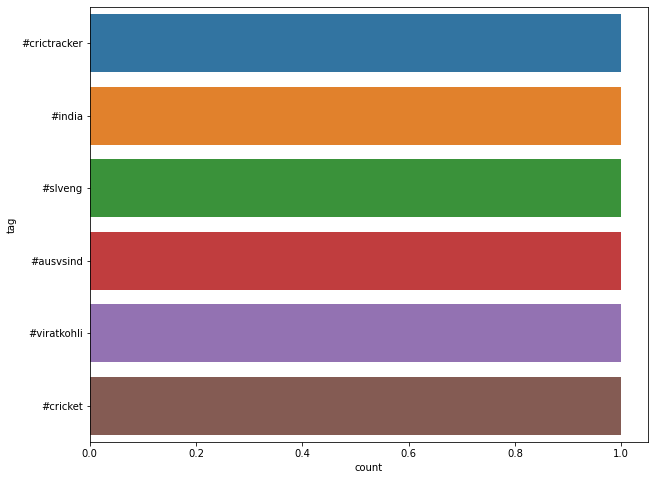

In [ ]:
count = 0
while count < 10:
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1

In [ ]:
ssc.stop()